In [11]:
import numpy as np

from numpy import loadtxt
from lmfit.models import GaussianModel,Model
from sklearn import mixture

from scipy.stats.distributions import norm
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde

    
from matplotlib import pyplot as plt
from matplotlib import cm

from scipy import ndimage as ndi
from scipy.spatial import distance
from numpy import linalg 

from skimage import io
from skimage.color import rgb2gray

from PIL import Image, ImageDraw, ImageFilter,ImageOps
import copy
import cv2

import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt as edt

from skimage.draw import ellipse
from skimage.measure import find_contours, approximate_polygon,subdivide_polygon



from grain_utils import grainPreprocess,grainShow,grainMark,grainDraw


In [2]:
grain1_name='Ultra_Co6_2-040.jpg'
grain2_name='Ultra_Co11-2.jpg'
grain3_name='Ultra_Co25-1.jpg'

path='images'

grain1_pil=Image.open(path+'/'+grain1_name)
grain2_pil=Image.open(path+'/'+grain2_name)
grain3_pil=Image.open(path+'/'+grain3_name)

h=150
image1=grainPreprocess.image_preprocess(grain1_pil,h=h)
image2=grainPreprocess.image_preprocess(grain2_pil,h=h)
image3=grainPreprocess.image_preprocess(grain3_pil,h=h)

D:\PROJECTS\python\grain_segmentation\grain_utils.py:45: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  image=rgb2gray(img)


In [3]:
def draw_edges(image,cnts,color=(50,50,50)):
    new_image=copy.copy(image)
    im = Image.fromarray(np.uint8(cm.gist_earth(new_image)*255))
    draw = ImageDraw.Draw(im)
    
    for j,cnt in enumerate(cnts):
        if len(cnt)>1:
            point=cnt[0]
            x1,y1=point[1],point[0]
            r=4
            
            for i,point2 in enumerate(cnt):
                p2=point2

                x2,y2=p2[1],p2[0]

                draw.ellipse((y2-r,x2-r,y2+r,x2+r), fill=color, width=5)
                draw.line((y1,x1,y2,x2), fill=(100,100,100), width=4)
                x1,y1=x2,y2

        else:
            continue

    img=np.array(im)

    return  img

In [4]:
def approx_polygon(contours):
    new_contours=[]
    for j,cnt in enumerate(contours):
        if len(cnt)>1:
            coords = approximate_polygon(cnt[:,0], tolerance=3)
            new_contours.append(coords)
        else:
            continue
    return new_contours

In [49]:
def angle_estimate(image,step):
    #
    # считаем углы с направлением обхода контура против часовой стрелки, углы >180 градусов учитываются
    #
    edges = cv2.Canny(image,0,255,L2gradient=False)
    contours, hierarchy = cv2.findContours( edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    approx=approx_polygon(contours)
    
    # определение знака обхода контура
    dirs=np.zeros((len(approx),1))
    for t,cnt in enumerate(approx):
        l=len(cnt)
        if l>2:
            for i in range(l)[1:l-1]:
                point1=cnt[i-1]
                point2=cnt[i]
                point3=cnt[i+1]
                x1,y1=point1[1],point1[0]
                x2,y2=point2[1],point2[0]
                x3,y3=point3[1],point3[0]

                v1=np.array((x1-x2,y1-y2)).reshape(1,2)
                v2=np.array((x3-x2,y3-y2)).reshape(1,2)

                v=np.concatenate([v1,v2])

                det=linalg.det(v)
                if det>0:
                    dirs[t]+=1
                else:
                    dirs[t]-=1
    
    # вычисление угла
    angles=[]
    for k,cnt in enumerate(approx):
        l=len(cnt)
        if l>2:
            for i in range(l)[1:l-1]:
                point1=cnt[i-1]
                point2=cnt[i]
                point3=cnt[i+1]
                x1,y1=point1[1],point1[0]
                x2,y2=point2[1],point2[0]
                x3,y3=point3[1],point3[0]

                v1=np.array((x1-x2,y1-y2)).reshape(1,2)
                v2=np.array((x3-x2,y3-y2)).reshape(1,2)

                dot=np.dot(v1[0],v2[0])
                dist1 = np.linalg.norm(v1[0])
                dist2 = np.linalg.norm(v2[0])
                cos=dot/(dist1*dist2)

                v=np.concatenate([v1,v2])
                det=linalg.det(v)

                if abs(cos)<1:
                    ang=int(np.arccos(cos)*180/np.pi) 
                    if (det>0 and dirs[k]>0) or (det<0 and dirs[k]<0):
                        angles.append(ang)
                    else:
                        angles.append(360-ang)
  
    for i,angle in enumerate(angles):
        while angles[i]%step!=0:
            angles[i]+=1

    angles_set=np.sort(np.array(list(set(angles))))
    dens_curve=[]
    for angle in angles_set:
        num=0
        for ang in angles:
            if angle==ang:
                num+=1
        dens_curve.append(num)
    return np.array(angles),angles_set,dens_curve

In [6]:
def gaussian(x, mu, sigma,amp=1):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return (amp/(np.sqrt(2*np.pi)*sigma))*np.exp(-(x-mu)**2 / (2*sigma**2))

def bimodal(x,mu1,sigma1,amp1,mu2,sigma2,amp2):
    return gaussian(x,mu1,sigma1,amp1)+gaussian(x,mu2,sigma2,amp2)

def gaussian_fit(y , x):
    gmodel = Model(bimodal)
    res = gmodel.fit(y, x=x, mu1=100,sigma1=10,amp1=1,mu2=250,sigma2=10,amp2=1)

    return res

In [145]:
def angles_approx(images,names,step,N):
    text=[]
    plt.figure(figsize=(N,N))
    for j,image in enumerate(images):
        angles,angles_set,dens_curve=angle_estimate(image,step)
        
        x = np.array(angles_set)
        y = np.array(dens_curve)

        norm=np.sum(y)
        bandwidth=0.5
        kde = gaussian_kde(angles, bw_method=bandwidth / x.std(ddof=1))
        pdf=kde.evaluate(x)
        
        res=gaussian_fit(y,x)
        
        mus=[res.params['mu1'].value,res.params['mu2'].value]
        sigmas=[res.params['sigma1'].value,res.params['sigma2'].value]
        amps=[res.params['amp1'].value,res.params['amp2'].value]

        x_gauss=range(0,361)
        
        print('new angles')
        print('mus',mus)
        print('sigmas',sigmas)
        
        gauss=np.array(bimodal(x_gauss,mus[0],sigmas[0],amps[0],mus[1],sigmas[1],amps[1]))
 #       text.append('sigma='+str(round(sigma1,2))+' mu=' +str(round(mu1,2)))

        plt.legend(text,fontsize=15)
        plt.plot(x,y/norm)
     #   plt.hist(angles,bins=100)
        plt.plot(gauss/norm)
      #  plt.scatter(x,y/norm)
    
    legend=[]
#    for k,name in enumerate(names):
#        legend.append(name+' '+text[k])
        
    plt.legend(legend,fontsize=15)
    plt.ylabel('количество углов/количество пустот, шт', fontsize=20)
    plt.xlabel('угол связующего вещества, градусы', fontsize=20)
    plt.show() #крупные

In [143]:
def angles_approx(images,names,step,N):
    text=[]
    plt.figure(figsize=(N,N))
    for j,image in enumerate(images):
        angles,angles_set,dens_curve=angle_estimate(image,step)
        
        x = np.array(angles_set)
        y = np.array(dens_curve)

        norm=np.sum(y)
        gmm = mixture.GaussianMixture(n_components=2, max_iter=10000, covariance_type='full').fit(angles.reshape(-1,1))

        mus=gmm.means_
        sigmas=gmm.covariances_
        print('new angles')      
        print('mus',mus)
        print('sigmas',sigmas)
        
        gauss=np.array(bimodal(x,mus[0],sigmas[0],1,mus[1],sigmas[1],1))[0]
        
      #  plt.plot(x, pdf, color='blue', alpha=0.5, lw=3)
        plt.plot(x,y/norm)
        plt.plot(x,gauss)
       # plt.fill(x,y)

    legend=[]
 #   for k,name in enumerate(names):
 #       legend.append(name+' '+text[k])
        
 #   plt.legend(legend,fontsize=15)
    plt.ylabel('количество углов/количество пустот, шт', fontsize=20)
    plt.xlabel('угол связующего вещества, градусы', fontsize=20)
    plt.show() #крупные

new angles
mus [115.84732361343701, 231.30084571172233]
sigmas [31.425919757527865, 24.54300283503205]


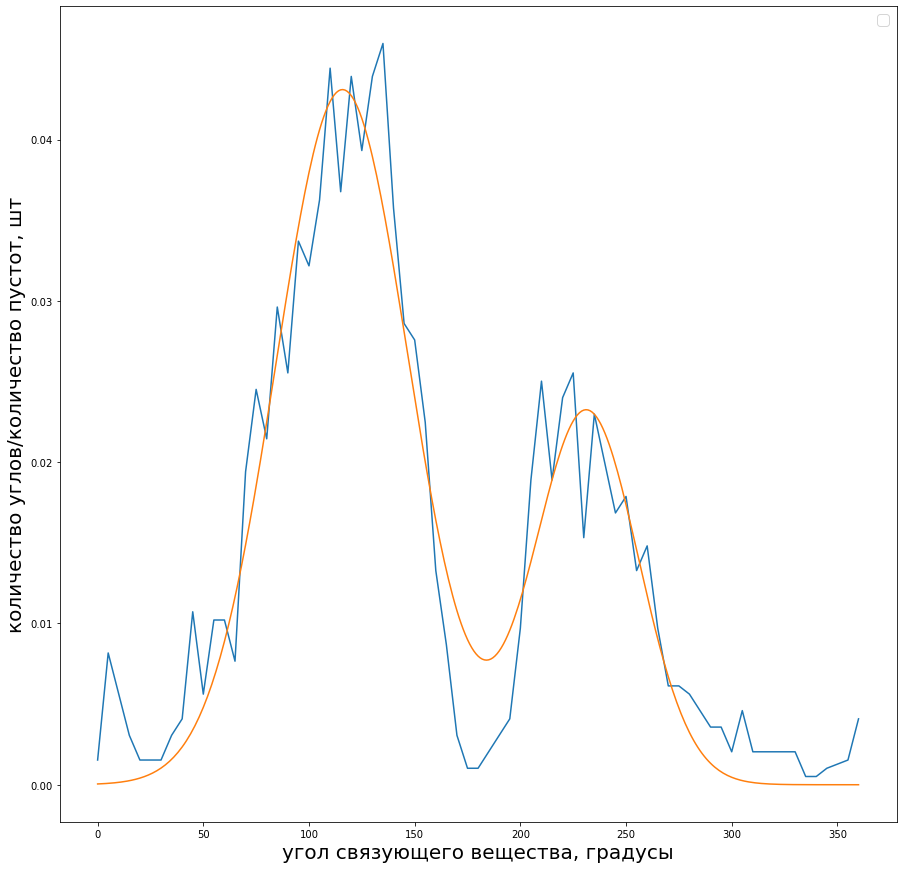

In [147]:
N=15
images=[image1,image2,image3]
images=[image2]
step=5
names=['сплав с крупными зернами','сплав с срединми зернами','сплав с мелкими зернами']
angles_approx(images,names,step,N)